In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import required libraries
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Define data directories
train_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train'
test_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test'

# Define transforms for training and testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Create dataloaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['AI_LD_art_nouveau', 'AI_LD_baroque', 'AI_LD_expressionism', 'AI_LD_impressionism', 'AI_LD_post_impressionism', 'AI_LD_realism', 'AI_LD_renaissance', 'AI_LD_romanticism', 'AI_LD_surrealism', 'AI_LD_ukiyo-e', 'AI_SD_art_nouveau', 'AI_SD_baroque', 'AI_SD_expressionism', 'AI_SD_impressionism', 'AI_SD_post_impressionism', 'AI_SD_realism', 'AI_SD_renaissance', 'AI_SD_romanticism', 'AI_SD_surrealism', 'AI_SD_ukiyo-e', 'art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']


In [4]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    model = model.to(device)
    
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_corrects = 0
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = correct / total
        test_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model, train_acc_history, test_acc_history


In [5]:
# Load pre-trained EfficientNetB4
efficientnet = models.efficientnet_b4(weights="IMAGENET1K_V1")
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, len(class_names))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.0001)

# Train EfficientNetB4
efficientnet_model, efficientnet_train_acc, efficientnet_test_acc = train_model(
    efficientnet, criterion, optimizer, train_loader, test_loader, num_epochs=10
)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 195MB/s]
100%|██████████| 2423/2423 [22:47<00:00,  1.77it/s]


Epoch [1/10] - Train loss: 0.7979 - Train Acc: 0.7349 - Val Acc: 0.8253


100%|██████████| 2423/2423 [22:43<00:00,  1.78it/s]


Epoch [2/10] - Train loss: 0.4518 - Train Acc: 0.8301 - Val Acc: 0.8474


100%|██████████| 2423/2423 [22:44<00:00,  1.78it/s]


Epoch [3/10] - Train loss: 0.3787 - Train Acc: 0.8572 - Val Acc: 0.8548


100%|██████████| 2423/2423 [22:44<00:00,  1.78it/s]


Epoch [4/10] - Train loss: 0.3257 - Train Acc: 0.8762 - Val Acc: 0.8602


100%|██████████| 2423/2423 [22:43<00:00,  1.78it/s]


Epoch [5/10] - Train loss: 0.2831 - Train Acc: 0.8934 - Val Acc: 0.8625


100%|██████████| 2423/2423 [22:43<00:00,  1.78it/s]


Epoch [6/10] - Train loss: 0.2418 - Train Acc: 0.9078 - Val Acc: 0.8621


100%|██████████| 2423/2423 [22:44<00:00,  1.78it/s]


Epoch [7/10] - Train loss: 0.2065 - Train Acc: 0.9218 - Val Acc: 0.8663


100%|██████████| 2423/2423 [22:46<00:00,  1.77it/s]


Epoch [8/10] - Train loss: 0.1741 - Train Acc: 0.9350 - Val Acc: 0.8623


100%|██████████| 2423/2423 [22:57<00:00,  1.76it/s] 


Epoch [9/10] - Train loss: 0.1455 - Train Acc: 0.9453 - Val Acc: 0.8605


100%|██████████| 2423/2423 [22:45<00:00,  1.77it/s]


Epoch [10/10] - Train loss: 0.1212 - Train Acc: 0.9554 - Val Acc: 0.8623


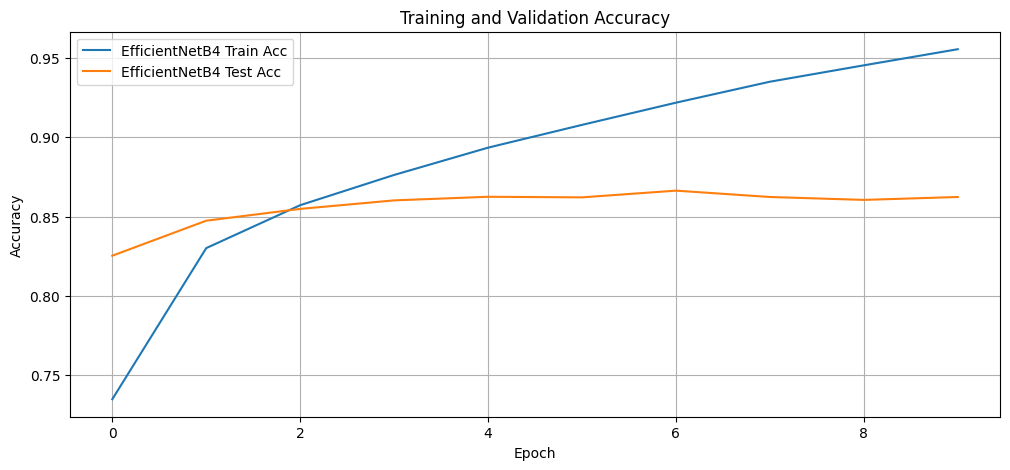

In [7]:
# Plot training curves
plt.figure(figsize=(12,5))
plt.plot(efficientnet_train_acc, label='EfficientNetB4 Train Acc')
plt.plot(efficientnet_test_acc, label='EfficientNetB4 Test Acc')
# plt.plot(vit_train_acc, label='ViT Train Acc')
# plt.plot(vit_test_acc, label='ViT Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Epoch 1/5 [Validation]: 100%|██████████| 469/469 [03:04<00:00,  2.54it/s]


Epoch [1/5] - Train Loss: 0.5557 - Train Acc: 0.7984 - Val Acc: 0.8094


Epoch 2/5 [Validation]: 100%|██████████| 469/469 [03:05<00:00,  2.53it/s]


Epoch [2/5] - Train Loss: 0.4020 - Train Acc: 0.8487 - Val Acc: 0.8021


Epoch 3/5 [Validation]: 100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


Epoch [3/5] - Train Loss: 0.3289 - Train Acc: 0.8761 - Val Acc: 0.8248


Epoch 4/5 [Validation]: 100%|██████████| 469/469 [03:03<00:00,  2.56it/s]


Epoch [4/5] - Train Loss: 0.2646 - Train Acc: 0.9009 - Val Acc: 0.8371


Epoch 5/5 [Validation]: 100%|██████████| 469/469 [03:03<00:00,  2.56it/s]


Epoch [5/5] - Train Loss: 0.2054 - Train Acc: 0.9230 - Val Acc: 0.8352


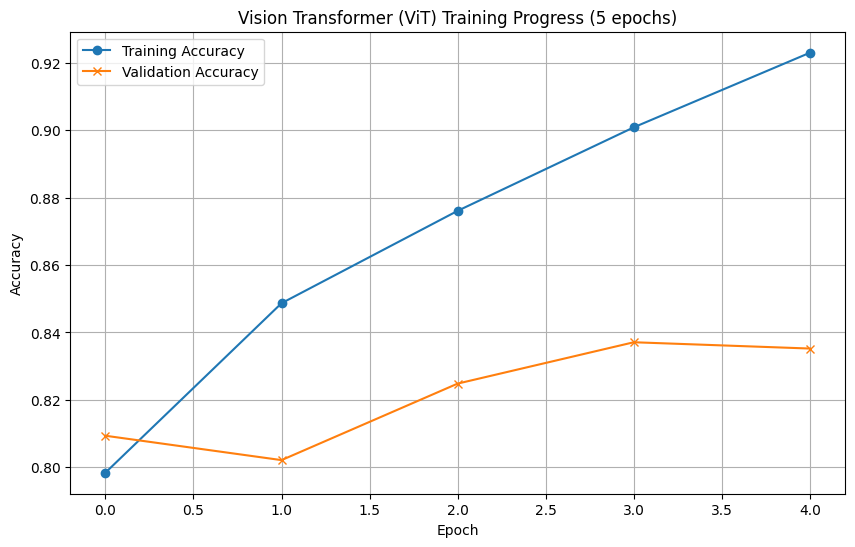

In [ ]:
#  Install torchvision if not installed
!pip install -q torchvision

#  Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

#  Make sure device is GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#  Load pre-trained Vision Transformer
vit_model = models.vit_b_16(weights="IMAGENET1K_V1")
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, len(class_names))  # 🔥 Corrected in_features

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)

#  Define Train Function
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=5):
    model = model.to(device)
    
    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_acc_history.append(epoch_acc.item())

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = correct / total
        test_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Acc: {val_acc:.4f}")

    return model, train_acc_history, test_acc_history

#  Train ViT Model for 5 epochs
vit_model, vit_train_acc, vit_test_acc = train_model(
    vit_model, criterion, optimizer, train_loader, test_loader, num_epochs=5
)

#  Plot Training vs Testing Accuracy
plt.figure(figsize=(10,6))
plt.plot(vit_train_acc, label='Training Accuracy', marker='o')
plt.plot(vit_test_acc, label='Validation Accuracy', marker='x')
plt.title('Vision Transformer (ViT) Training Progress (5 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()l
plt.grid()
plt.show()
